pascalvoc: resize original images

Strategy:
1. Read: Images RGB / Masks RGB (original dataset)
2. Pad (512,512) for training
3. Save: Images RGB / Masks RGB

In [1]:
padsize = (512,512)

(512, 512)

environment

In [2]:
using Pkg
envpath = expanduser("~/envs/deeptraining/")
Pkg.activate(envpath)

  Activating project at `~/envs/deeptraining`


In [3]:
# libs
using Images
using DataFrames
using CSV
using FLoops

In [4]:
# private libs
using PreprocessingImages; p=PreprocessingImages

PreprocessingImages

In [5]:
# input folders
datasetPath  = "/scratch/cirobr/datasets/pascalvoc/VOCdevkit/VOC2012/"
imagesPath   = datasetPath * "JPEGImages/"
masksPath    = datasetPath * "SegmentationClass/"
cowslist     = datasetPath * "ImageSets/Main/cow_trainval.txt"

# output folders
workpath = pwd() * "/"
workpath = replace(workpath, homedir() => "~")
resizedImagesPath = workpath * "resized/images/"
resizedMasksPath  = workpath * "resized/masks/"
mkpath(expanduser(resizedImagesPath))
mkpath(expanduser(resizedMasksPath))

"/home/cirobr/projects/deeptraining/dataset/resized/masks"

input dataset

In [6]:
fpfn = expanduser(workpath) * "dftrain-coi.csv"
dftrain = CSV.read(fpfn, DataFrame)
fpfn = expanduser(workpath) * "dfvalid-coi.csv"
dfvalid = CSV.read(fpfn, DataFrame)
fpfn = expanduser(workpath) * "dftest-coi.csv"
dftest = CSV.read(fpfn, DataFrame);

resize dataset

In [7]:
# resize images and masks
dfs   = [dftrain, dfvalid, dftest]

for df in dfs
@floop for row in eachrow(df)
    # images
    local fpfn = expanduser(row.X)
    img = Images.load(fpfn)                          # read
    img = p.center_padview(img, padsize) .|> RGB     # pad
    local fpfn = expanduser(resizedImagesPath) * basename(fpfn)
    Images.save(fpfn, img)                           # save

    # masks
    if row.segmented == 1
        local fpfn = expanduser(row.y)
        mask = Images.load(fpfn)                          # read
        mask = p.center_padview(mask, padsize) .|> RGB    # pad
        local fpfn = expanduser(resizedMasksPath) * basename(fpfn)
        Images.save(fpfn, mask)                           # save
    end
end
end

In [8]:
# create data frames
dftrain_resized = dftrain
dftrain_resized.X = resizedImagesPath .* basename.(dftrain.X)
dftrain_resized.y = [row.segmented == 1 ? resizedMasksPath * basename(row.y) : row.y for row in eachrow(dftrain)]

dfvalid_resized = dfvalid
dfvalid_resized.X = resizedImagesPath .* basename.(dfvalid.X)
dfvalid_resized.y = [row.segmented == 1 ? resizedMasksPath * basename(row.y) : row.y for row in eachrow(dfvalid)]

dftest_resized = dftest
dftest_resized.X = resizedImagesPath .* basename.(dftest.X)
dftest_resized.y = [row.segmented == 1 ? resizedMasksPath * basename(row.y) : row.y for row in eachrow(dftest)]

# save data frames
fpfn = expanduser(workpath) * "dftrain-coi-resized.csv"
CSV.write(fpfn, dftrain_resized)
fpfn = expanduser(workpath) * "dfvalid-coi-resized.csv"
CSV.write(fpfn, dfvalid_resized)
fpfn = expanduser(workpath) * "dftest-coi-resized.csv"
CSV.write(fpfn, dftest_resized)

"/home/cirobr/projects/deeptraining/dataset/dftest-coi-resized.csv"

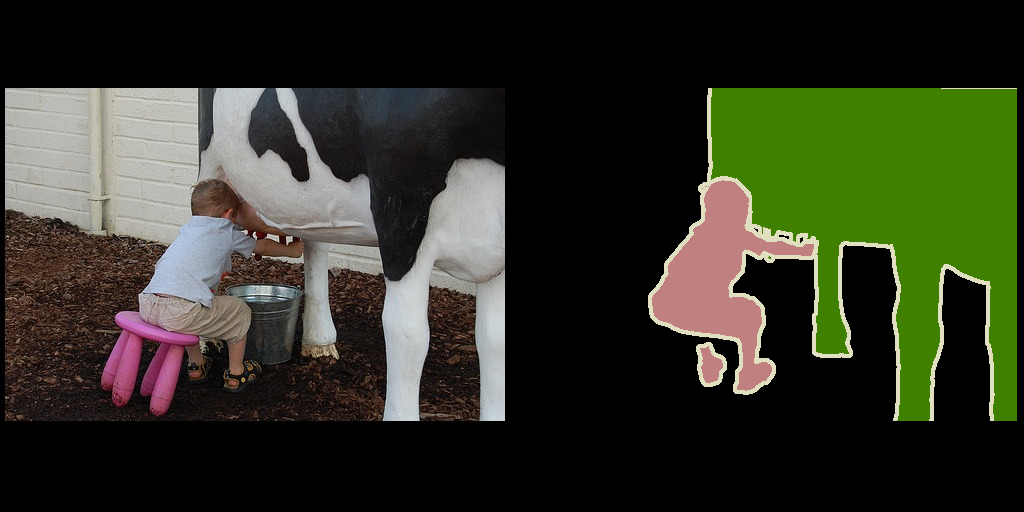

In [9]:
# checkpoint
dftrain = CSV.read(expanduser(workpath) * "dftrain-coi-resized.csv", DataFrame)
df = dftrain[dftrain.segmented .== 1, :]

k = rand(1:size(df, 1))
img = Images.load(expanduser(df.X[k]))
msk = Images.load(expanduser(df.y[k]))
mosaicview([img, msk]; nrow=1)